In [1]:
import os
import shutil
import numpy as np
import cv2
#~ импортируем библиотеку gdown, которая используется для загрузки файлов
import gdown
import time
import datetime

In [2]:
#~ фиксирую время начала выполнения процесса
time1 = time.time()

In [3]:
!pip install autokeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.7/122.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.1/644.1 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 23.8 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.0
    Uninstalling tensorboard-2.17.0:
      Successfully uninstalled tensorboard-2.17.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.0
    Uninstalling tensorflow-2.17.0:
    

In [4]:
#~ и скачиваем дадасет с пожарами
gdown.download('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1a6JeOPWfsDGSopgWrXHnj-JVsRc75h1s', None, quiet=True)

'dataset_fire4.zip'

In [5]:
!unzip -qo dataset_fire4.zip -d /content/

In [6]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#~ настраиваемые парметры для расчета модели
#~~~~~~~~~~~~~~~~~~~~~~~~
#~ ширина-высота сжатого изображения для нейронки
#~ target_imgwh2 - target_img_width_height2
target_imgwh2 = 224
#~~~~~~~~~~~~~~~~~~~~~~~~
#~ tuner (тюнер): оптимизатор для подбора архитектуры модели.
#~ можно выбрать “random”, “bayesian”, “hyperband” или “greedy”.
#~ random
#~ bayesian
#~ hyperband
#~ greedy
# tuner_type2 = 'random'
tuner_type2 = 'bayesian'
# tuner_type2 = 'hyperband'
# tuner_type2 = 'greedy'
#~~~~~~~~~~~~~~~~~~~~~~~~
#~ max_trials2: максимальное количество раз, которое “AutoKeras” будет искать модели (по умолчанию 100).
#~ в начале 5го trial память google colab закончена
max_trials2 = 4 #3 1 2 3
#~~~~~~~~~~~~~~~~~~~~~~~~
#~ epochs: количество эпох для обучения модели “AutoKeras”
epochs2 = 10 #20, 5, 10, 20, 40, 150
#~ epochs: количество эпох для дообучения лучшей модели
epochs3 = 40 #20 30 40
#~~~~~~~~~~~~~~~~~~~~~~~~
#~ patience(терпение): определяет количество эпох без улучшения валидационной потери перед остановкой обучения (ранняя остановка).
patience2 = 5 #3 5

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#~ отображаю значения параметров
#~~~~~~~~~~~~~~~~~~~~~~~~
print(f'[INFO] target_imgwh2: {target_imgwh2}')
print(f'[INFO] tuner_type2: `{tuner_type2}`')
print(f'[INFO] max_trials2: {max_trials2}')
print(f'[INFO] epochs2: {epochs2}')
print(f'[INFO] epochs3: {epochs3}')
print(f'[INFO] patience2: {patience2}')

[INFO] target_imgwh2: 224
[INFO] tuner_type2: `bayesian`
[INFO] max_trials2: 4
[INFO] epochs2: 10
[INFO] epochs3: 40
[INFO] patience2: 5


In [7]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#~ пути к данным
#~~~~~~~~~~~~~~~~~~~~~~~~
#~ директория с датасетом
# src_dir1 = 'c:/dataset_fire4'
# /content/dataset_fire4/test/fire/f_01170-1f223ccc-7104-11ef-8ce9-bcee7b784ecb.jpg
src_dir1 = '/content/dataset_fire4'
#~ директории с датасетом
train_dir1 = os.path.join(src_dir1, 'train')
valid_dir1 = os.path.join(src_dir1, 'valid')
test_dir1 = os.path.join(src_dir1, 'test')
#~~~~~~~~~~~~~~~~~~~~~~~~
#~ список категорий классов
classes_lst1 = ['fire', 'non-fire']
#~~~~~~~~~~~~~~~~~~~~~~~~
#~ директория с результатами
dst_dir2 = '/content/dataset_fire5_result_tuner_'+tuner_type2
#~ удаляю директорию с предыдущими результатами, если они были
if os.path.exists(dst_dir2):
  shutil.rmtree(dst_dir2)
#~ создаю директорию для результатов
os.makedirs(dst_dir2)
#~~~~~~~~~~~~~~~~~~~~~~~~
#~ путь к папке, где “AutoKeras” будет сохранять результаты (по умолчанию “auto-keras”).
# dst_autodir2 = os.path.join(dst_dir2, 'auto_keras5')
dst_autodir2 = '/content/auto_keras5_temp'
#~ создаю директорию для результатов
if not os.path.exists(dst_autodir2):
  os.makedirs(dst_autodir2)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#~ отображаю значения параметров
#~~~~~~~~~~~~~~~~~~~~~~~~
print(f'[INFO] src_dir1: `{src_dir1}`')
print(f'[INFO]  train_dir1: `{train_dir1}`')
print(f'[INFO]  valid_dir1: `{valid_dir1}`')
print(f'[INFO]  test_dir1: `{test_dir1}`')
print(f'[INFO] classes_lst1: len: {len(classes_lst1)}, `{classes_lst1}`')
print(f'[INFO] dst_dir2: `{dst_dir2}`')
print(f'[INFO] dst-autodir2: `{dst_autodir2}`')

[INFO] src_dir1: `/content/dataset_fire4`
[INFO]  train_dir1: `/content/dataset_fire4/train`
[INFO]  valid_dir1: `/content/dataset_fire4/valid`
[INFO]  test_dir1: `/content/dataset_fire4/test`
[INFO] classes_lst1: len: 2, `['fire', 'non-fire']`
[INFO] dst_dir2: `/content/dataset_fire5_result_tuner_bayesian`
[INFO] dst-autodir2: `/content/auto_keras5_temp`


In [8]:
#~ функция для получения списка имен image-файлов
def get_image_list(directory_path: str) -> list[str]:
  img_lst = []
  #~~~~~~~~~~~~~~~~~~~~~~~~
  if not os.path.exists(directory_path):
    return img_lst
  #~~~~~~~~~~~~~~~~~~~~~~~~
  for fname in os.listdir(directory_path):
    if os.path.isfile(os.path.join(directory_path, fname)):
      if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')):
        img_lst.append(fname)
  #~~~~~~~~~~~~~~~~~~~~~~~~
  return img_lst

In [9]:
#~ функция для загрузки изображений и меток
def load_images_labels(data_dir1: str):
  images = []
  labels = []
  #~ ширина-высота сжатого изображения для нейронки
  #~ target_imgwh2 - target_img_width_height2
  target_size2 = (target_imgwh2, target_imgwh2)
  # print(f'[INFO] target_imgwh2: {target_imgwh2}')
  #~~~~~~~~~~~~~~~~~~~~~~~~
  for i in range(len(classes_lst1)):
    # print(f'[INFO] {i}: {classes_lst1[i]}')
    category_dir1 = os.path.join(data_dir1, classes_lst1[i])
    # print(f'[INFO]  category_dir1: {category_dir1}')
    # [INFO] Test
    # [INFO] 0: fire
    # [INFO]  category_dir1: d:/dataset_fire4\test\fire
    # [INFO]  img_lst1: len: 13
    # [INFO] 1: non-fire
    # [INFO]  category_dir1: d:/dataset_fire4\test\non-fire
    # [INFO]  img_lst1: len: 13
    #~~~~~~~~~~~~~~~~~~~~~~~~
    img_lst1 = get_image_list(category_dir1)
    img_lst_len1 = len(img_lst1)
    if img_lst_len1 < 1:
      print('[WARNING]  img_lst1 is empty')
      continue
    # print(f'[INFO]  img_lst1: len: {img_lst_len1}')
    #~~~~~~~~~~~~~~~~~~~~~~~~
    #~ побежали по изображениям в списке
    for j in range(img_lst_len1):
      # print(f'[INFO]  {j}->{img_lst_len1-1}: `{img_lst1[j]}`')
      # [INFO]  12->12: `nf_01182-fcf9ab75-7110-11ef-a68f-bcee7b784ecb.jpg`
      img_fname1 = os.path.join(category_dir1, img_lst1[j])
      # print(f'[INFO]  2-> img_fname1: `{img_fname1}`')
      # [INFO]  2-> img_fname1: `d:/dataset_fire4\test\non-fire\nf_01182-fcf9ab75-7110-11ef-a68f-bcee7b784ecb.jpg`
      #~~~~~~~~~~~~~~~~~~~~~~~~
      #~ открываем изображение с использованием библиотеки opencv
      img_cv = cv2.imread(img_fname1)
      # print(f'[INFO]  3-> type(img_cv): {type(img_cv)}, img_cv.shape: {img_cv.shape}')
      # print(f'[INFO]  4-> type(img_cv[0][0][0]): {type(img_cv[0][0][0])}, img_cv[0][0][0]: {img_cv[0][0][0]}')
      # [INFO]  3-> type(img_cv): <class 'numpy.ndarray'>, img_cv.shape: (224, 224, 3)
      # [INFO]  4-> type(img_cv[0][0][0]): <class 'numpy.uint8'>, img_cv[0][0][0]: 0
      #~~~~~~~~~~~~~~~~~~~~~~~~
      img_width = 0
      img_height = 0
      try:
        img_width = img_cv.shape[1]
        img_height = img_cv.shape[0]
        # print(f'[INFO]  5-> img_width: {img_width}, img_height: {img_height}, target_imgwh2: {target_imgwh2}, target_size2: {target_size2}')
        # [INFO]  5-> img_width: 224, img_height: 224, target_imgwh2: 224, target_size2: (224, 224)
      except:
        print(f'[WARNING] corrupted image: {img_fname1}')
        continue
      #~~~~~~~~~~~~~~~~~~~~~~~~
      #~ сжимаем изображение
      if img_width != target_imgwh2 or img_height != target_imgwh2:
        img_cv = cv2.resize(img_cv, target_size2, interpolation=cv2.INTER_AREA)
      #~~~~~~~~~~~~~~~~~~~~~~~~
      #~ и нормализуем значения пикселей - делим на 255, приводим к диапазону [0..1]
      img_cv = img_cv/255.0
      # print(f'[INFO]  6-> type(img_cv): {type(img_cv)}, img_cv.shape: {img_cv.shape}')
      # print(f'[INFO]  7-> type(img_cv[0][0][0]): {type(img_cv[0][0][0])}, img_cv[0][0][0]: {img_cv[0][0][0]}')
      # [INFO]  6-> type(img_cv): <class 'numpy.ndarray'>, img_cv.shape: (224, 224, 3)
      # [INFO]  7-> type(img_cv[0][0][0]): <class 'numpy.float64'>, img_cv[0][0][0]: 0.0
      #~~~~~~~~~~~~~~~~~~~~~~~~
      #~ добавляем нормализованную картинку массив в список
      images.append(img_cv)
      #~~~~~~~~~~~~~~~~~~~~~~~~
      labels.append(i)
  #~~~~~~~~~~~~~~~~~~~~~~~~
  #~ для уменьшения расходования памяти приводим тип данных от по умолчанию float64 к float32
  #~ и форма хранения данных - массив - <class 'numpy.ndarray'>
  images32 = np.array(images).astype(np.float32)
  labels32 = np.array(labels).astype(np.float32)
  #~~~~~~~~~~~~~~~~~~~~~~~~
  return images32, labels32

In [10]:
#~ загружаю train-valid-test массивы-данных
#~ train
X_train, y_train = load_images_labels(train_dir1)
#~ valid
X_valid, y_valid = load_images_labels(valid_dir1)
#~ test
X_test, y_test = load_images_labels(test_dir1)

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from keras.callbacks import EarlyStopping
from tensorflow.keras import utils

import autokeras as ak

import matplotlib.pyplot as plt

In [12]:
#~ cоздаем экземпляр классификатора
clf = ak.ImageClassifier(
  tuner=tuner_type2,
  max_trials=max_trials2,
  objective='val_accuracy',
  overwrite=True,
  directory=dst_autodir2)

In [13]:
#~ create an EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=patience2, restore_best_weights=True)

In [14]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#~ обучаем модель
#~~~~~~~~~~~~~~~~~~~~~~~~
#~ self.X_train - обучающая выборка параметров
#~ self.y_train - обучающая выборка меток класса
#~ self.X_valid, self.y_valid - валидационные данные
#~~~~~~~~~~~~~~~~~~~~~~~~
clf.fit(
  X_train,
  y_train,
  validation_data=(X_valid, y_valid),
  epochs=epochs2,
  callbacks=[early_stopping],
  verbose=1
)

Trial 4 Complete [00h 03m 30s]
val_accuracy: 0.5

Best val_accuracy So Far: 0.9502924084663391
Total elapsed time: 00h 17m 03s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [15]:
#~ экспортируем лучшую модель
best_model = clf.export_model()

In [16]:
#~ вывод структуры модели в виде графического файла
print(best_model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_to_float32 (CastToFloat32)      │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip (RandomFlip)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 7, 7, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │         100,353 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification_head_1 (Activation)   │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,961,833 (79.96 MB)

 Trainable params: 100,353 (392.00 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

None


[INFO] model_summary_fname: `/content/dataset_fire5_result_tuner_bayesian/best_model_summary.png`


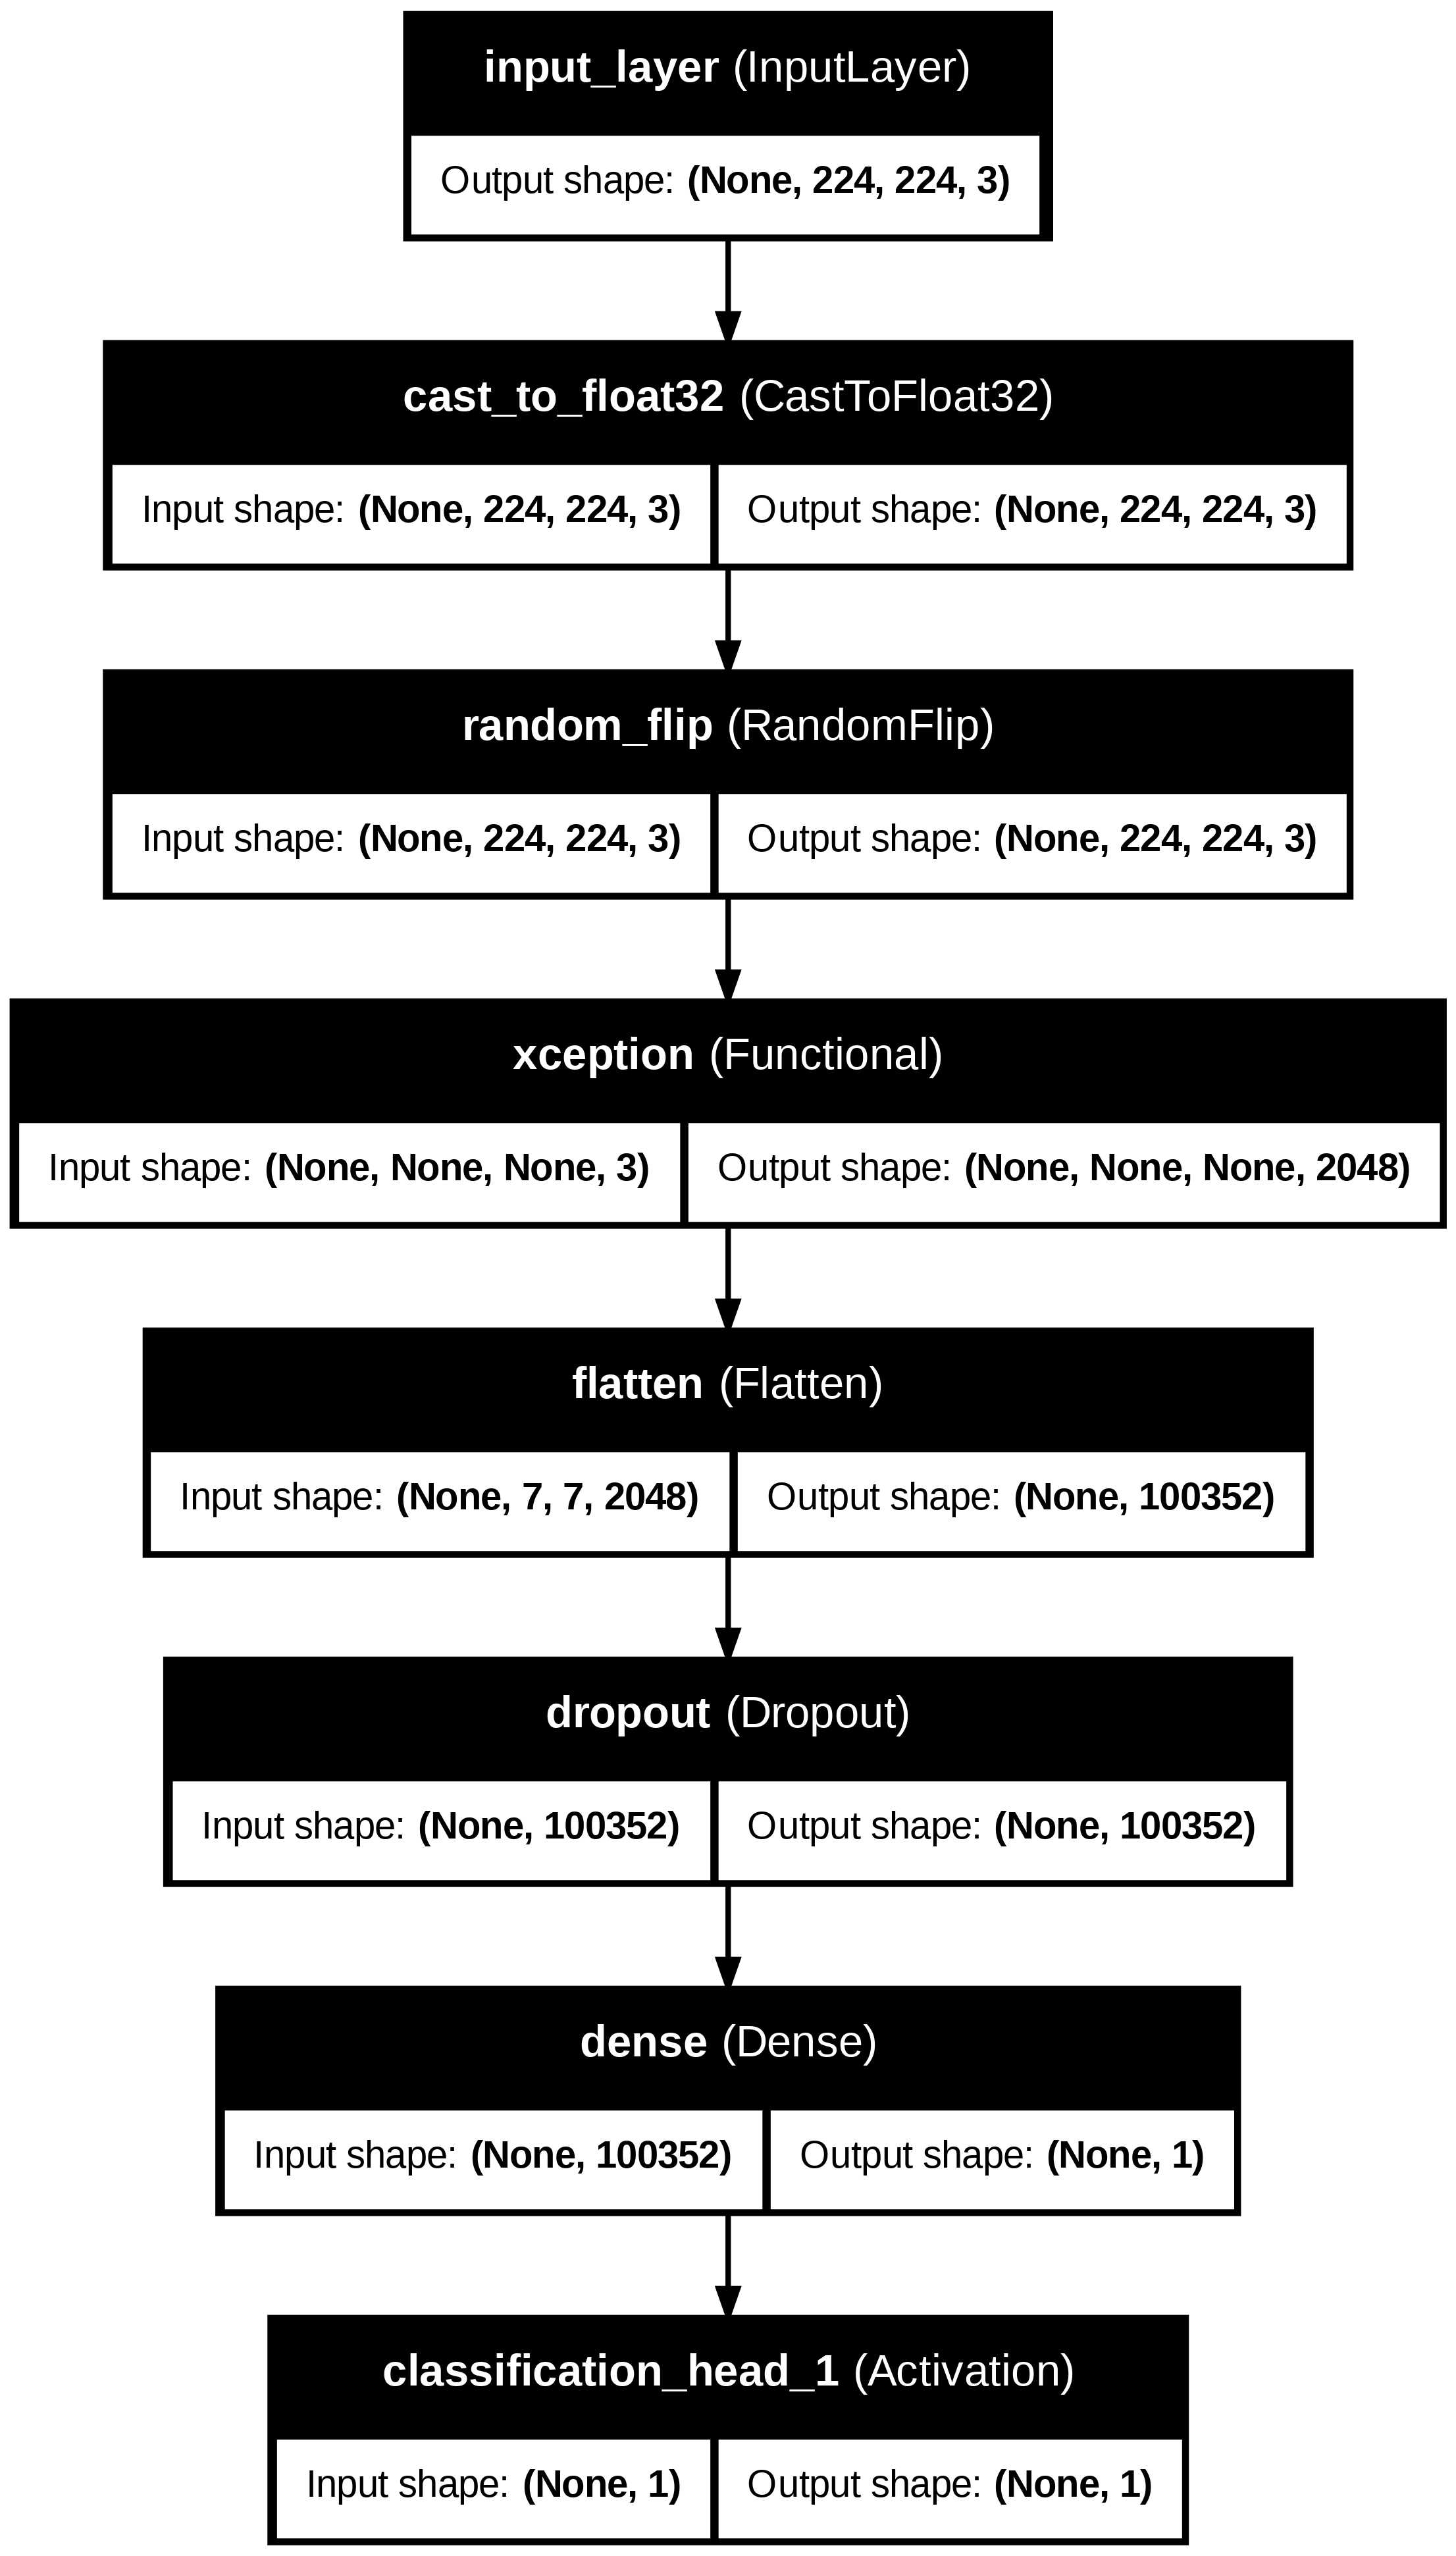

In [17]:
#~ и сохраняем ее графический файл
dst_autodir2 = os.path.join(dst_dir2, 'auto_keras5')
model_summary_fname = os.path.join(dst_dir2, 'best_model_summary.png')
print(f'[INFO] model_summary_fname: `{model_summary_fname}`')
utils.plot_model(best_model, to_file=model_summary_fname, show_shapes=True, show_layer_names=True, dpi=300)

In [18]:
#~ вывод структуры модели в виде текстового файла
#~~~~~~~~~~~~~~~~~~~~~~~~
#~ bml: best model layer
bml_fname = os.path.join(dst_dir2, 'best_model_layers.txt')
print(f'[INFO] best model layer fname: `{bml_fname}`')
bml_file = open(bml_fname, 'w', encoding='utf-8')
#~ печатаем заголовок
bml_file.write("Layer details:\n")
#~ проходимся по каждому слою модели
for layer in best_model.layers:
  #~ записываем имя слоя
  bml_file.write(f"Layer name: {layer.name}\n")
  #~ записываем тип слоя
  bml_file.write(f"Layer type: {type(layer)}\n")
  #~ получаем конфигурацию слоя
  config = layer.get_config()
  #~ записываем конфигурацию слоя
  bml_file.write("Layer configuration:\n")
  for key, value in config.items():
    bml_file.write(f"  {key}: {value}\n")
  #~ делаем пустую строку между слоями
  bml_file.write("\n")
#~~~~~~~~~~~~~~~~~~~~~~~~
bml_optimizer = best_model.optimizer
bml_learning_rate = bml_optimizer.learning_rate
#~ пишем название оптимизатора
bml_file.write(f"\nOptimizer: {type(bml_optimizer).__name__}\n")
#~ пишем значение learning_rate
bml_file.write(f"Learning rate: {bml_learning_rate}\n")
#~ закрываем файл
bml_file.close()

[INFO] best model layer fname: `/content/dataset_fire5_result_tuner_bayesian/best_model_layers.txt`


In [19]:
#~ дообучаем лучшую модель
history = best_model.fit(x=X_train,                          #Обучающая выборка параметров
                         y=y_train,                          #Обучающая выборка меток класса
                         epochs=epochs3,                     #Количество эпох обучения
                         validation_data=(X_valid, y_valid), #Валидационные данные
                         callbacks=[early_stopping],         #без улучшения валидационной потери остановливаемся
                         verbose=1,                          #Отображение хода обучения
                         shuffle=True                        #Перемешивание перед каждой эпохой
                         )

Epoch 1/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 348ms/step - accuracy: 0.9925 - loss: 0.5164 - val_accuracy: 0.9503 - val_loss: 7.5130
Epoch 2/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 31s 228ms/step - accuracy: 0.9793 - loss: 1.1266 - val_accuracy: 0.9488 - val_loss: 7.7138
Epoch 3/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 233ms/step - accuracy: 0.9947 - loss: 0.2600 - val_accuracy: 0.9532 - val_loss: 7.3324
Epoch 4/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 191ms/step - accuracy: 0.9861 - loss: 0.6028 - val_accuracy: 0.9532 - val_loss: 7.0404
Epoch 5/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 192ms/step - accuracy: 0.9889 - loss: 0.2972 - val_accuracy: 0.9532 - val_loss: 6.1045
Epoch 6/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 188ms/step - accuracy: 0.9930 - loss: 0.1295 - val_accuracy: 0.9342 - val_loss: 7.6617
Epoch 7/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 230ms/step - accuracy: 0.9929 - loss: 0.1491 - val_accuracy: 0.9561 - val_loss: 6.5183
Epoch 8/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 178ms/step - accuracy: 0.9972 - loss: 0.0711 - val_accu

In [20]:
#~ Обучение модели завершено
#~ сохраняем рассчитанные веса в файл
event_datetime = datetime.datetime.now()
# model_fname = f'model{event_datetime.strftime("%Y.%m.%d %H:%M:%S")}.h5'
model_fname = f'model{event_datetime.strftime("%Y%m%d")}.h5'
# print(f'[INFO] model_fname: `{model_fname}`')
model_fpath = os.path.join(dst_dir2, model_fname)
print(f'[INFO] saved model: `{model_fpath}`')
#~ cохраняем только веса
# model.save_weights('model.h5')
#~ cохраняем модель и веса
best_model.save(model_fpath)

[INFO] saved model: `/content/dataset_fire5_result_tuner_bayesian/model20241108.h5`


In [21]:
model_fnameK = f'model{event_datetime.strftime("%Y%m%d")}k.keras'
model_fpathK = os.path.join(dst_dir2, model_fnameK)
print(f'[INFO] saved modelK: `{model_fpathK}`')
best_model.save(model_fpathK)

[INFO] saved modelK: `/content/dataset_fire5_result_tuner_bayesian/model20241108k.keras`


In [22]:
#~ оценка и предсказание модели на тестовом наборе
evaluation_fname = os.path.join(dst_dir2, 'model_evaluation.txt')
print(f'[INFO] evaluation fname: `{evaluation_fname}`')
#~ оценка модели на тестовых данных
test_loss, test_acc = best_model.evaluate(X_test, y_test)
evaluation_str = f'Точность на тестовом наборе: {round(test_acc*100, 1)}%'
print(f'[INFO] {evaluation_str}')
#~ cохранение точности в текстовый файл
with open(evaluation_fname, 'w', encoding='utf-8') as f:
  f.write(evaluation_str)

[INFO] evaluation fname: `/content/dataset_fire5_result_tuner_bayesian/model_evaluation.txt`
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.9615 - loss: 0.8768
[INFO] Точность на тестовом наборе: 96.2%


In [23]:
#~ предсказание модели на тестовых изображениях
predict_dir = os.path.join(dst_dir2, 'predict')
if not os.path.exists(predict_dir):
  os.makedirs(predict_dir)
#~~~~~~~~~~~~~~~~~~~~~~~~
#~ количество изображений
X_test_shape = X_test.shape
y_test_shape = y_test.shape
img_count = X_test_shape[0]
lbl_count = y_test_shape[0]
print(f'[INFO] img_count: {img_count}, lbl_count: {lbl_count}')
#~~~~~~~~~~~~~~~~~~~~~~~~
for i in range(lbl_count):
  # print(f'[INFO] i: {i}')
  #~~~~~~~~~~~~~~~~~~~~~~~~
  Ximg = X_test[i]
  #~ добавление одной оси в начале, чтобы нейронка могла распознать пример
  Xexd = np.expand_dims(Ximg, axis=0)
  #~ распознавание примера изображения - определение его класса
  prediction = best_model.predict(Xexd, verbose=0)
  # pred = prediction[0][0]
  # print(f'[INFO]  ===>class: {int(self.y_test[i])} -> prediction: {prediction}')
  # print(f'[INFO]   ==>type(prediction): {type(prediction)}, shape: {prediction.shape}, dtype: {prediction.dtype}')
  # print(f'[INFO]    =>pred: {pred}')
  pred_inx = 0
  if prediction[0][0] > 0.5:
    pred_inx = 1
  # print(f'[INFO]  ===>class: {int(self.y_test[i])} -> prediction: {pred_inx} ({prediction[0][0]})')
  # [INFO]  ===>class: 0 -> prediction: 0 (6.1594523660464736e-18)
  # [INFO]  ===>class: 1 -> prediction: 1 (0.9999997615814209)
  #~~~~~~~~~~~~~~~~~~~~~~~~
  #~ сохраняем распознанные изображения из тестовой папки
  fname2 = f'original{int(y_test[i])}_predict{pred_inx}_inx{i}.jpg'
  img_fname2 = os.path.join(predict_dir, fname2)
  # print(f'[INFO]  img_fname2: `{img_fname2}`')
  class_inx = int(y_test[i])
  class_lbl = f'original: {classes_lst1[class_inx]}'
  pred_lbl = f'predict: {classes_lst1[pred_inx]}'
  #~~~~~~~~~~~~~~~~~~~~~~~~
  class_color = (0, 0, 255)
  if 1 == class_inx:
    class_color = (255, 0, 0)
  #~~~~~~~~~~~~~~~~~~~~~~~~
  pred_color = (0, 0, 255)
  if 1 == pred_inx:
    pred_color = (255, 0, 0)
  #~~~~~~~~~~~~~~~~~~~~~~~~
  Ximg255 = (Ximg*255.0).astype(np.uint8)
  cv2.rectangle(Ximg255, (0,0), (168,48), (255,255,255), -1)
  cv2.putText(Ximg255, class_lbl, (2,17), cv2.FONT_HERSHEY_SIMPLEX, 0.6, class_color, 1, cv2.LINE_AA)
  cv2.putText(Ximg255, pred_lbl, (2,40), cv2.FONT_HERSHEY_SIMPLEX, 0.6, pred_color, 1, cv2.LINE_AA)
  cv2.imwrite(img_fname2, Ximg255)

[INFO] img_count: 26, lbl_count: 26


In [24]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [25]:
#~ визуализация потерь (loss)
fig = plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('График потерь (Loss)')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()
plt.grid(True)
# plt.show()
#~~~~~~~~~~~~~~~~~~~~~~~~
#~ сохранение графика в файл PNG
fname = f'loss_curve.png'
loss_fname = os.path.join(dst_dir2, fname)
print(f'[INFO] loss_fname: `{loss_fname}`')
#~ - **outputpath**: Полный путь до файла, куда будет сохранён график.
#~ - **dpi**: Число точек на дюйм (dots per inch), определяющее разрешение изображения. Чем больше значение dpi,
#~  тем выше качество изображения, но и размер файла также увеличивается. Значение по умолчанию часто составляет 100,
#~  но для лучшего качества можно использовать значения около 300 или выше.
#~ - **bboxinches**: Этот параметр управляет обрезанием рамки вокруг графика при сохранении. По умолчанию используется
#~  'standard', что приводит к тому, что внешние границы графика обрезаются до A4 страницы.
#~  'tight' включает весь график, но оставляет достаточно места для осей и меток.
plt.savefig(loss_fname, dpi=300, bbox_inches='tight')
plt.close(fig)

[INFO] loss_fname: `/content/dataset_fire5_result_tuner_bayesian/loss_curve.png`


In [26]:
#~ визуализация метрики (accuracy)
fig = plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('График точности (Accuracy)')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()
plt.grid(True)
# plt.show()
#~~~~~~~~~~~~~~~~~~~~~~~~
#~ сохранение графика в файл PNG
fname = f'accuracy_curve.png'
accuracy_fname = os.path.join(dst_dir2, fname)
print(f'[INFO] accuracy_fname: `{accuracy_fname}`')
plt.savefig(accuracy_fname, dpi=300, bbox_inches='tight')
plt.close(fig)

[INFO] accuracy_fname: `/content/dataset_fire5_result_tuner_bayesian/accuracy_curve.png`


In [27]:
#~ архивируем результаты, чтобы их можно было скачать
archive2 = '/content/result_'+tuner_type2+'.zip'
print(f'[INFO] archive2: `{archive2}`')
!zip -r {archive2} {dst_dir2}

[INFO] archive2: `/content/result_bayesian.zip`
  adding: content/dataset_fire5_result_tuner_bayesian/ (stored 0%)
  adding: content/dataset_fire5_result_tuner_bayesian/best_model_summary.png (deflated 18%)
  adding: content/dataset_fire5_result_tuner_bayesian/model_evaluation.txt (deflated 10%)
  adding: content/dataset_fire5_result_tuner_bayesian/predict/ (stored 0%)
  adding: content/dataset_fire5_result_tuner_bayesian/predict/original1_predict1_inx20.jpg (deflated 1%)
  adding: content/dataset_fire5_result_tuner_bayesian/predict/original1_predict1_inx22.jpg (deflated 1%)
  adding: content/dataset_fire5_result_tuner_bayesian/predict/original0_predict0_inx1.jpg (deflated 1%)
  adding: content/dataset_fire5_result_tuner_bayesian/predict/original0_predict0_inx0.jpg (deflated 1%)
  adding: content/dataset_fire5_result_tuner_bayesian/predict/original0_predict0_inx5.jpg (deflated 1%)
  adding: content/dataset_fire5_result_tuner_bayesian/predict/original1_predict1_inx15.jpg (deflated 1%)
 

In [28]:
#~ отображаю время, затраченное на выполнение всей программы
result_time2 = time.time() - time1
result_hour2 = int(result_time2//3600)
result_min2 = int(result_time2//60) - result_hour2*60
result_sec2 = int(round(result_time2%60))
result_msec2 = round(1000*result_time2%60)
execution_time2 = ''
if result_hour2 > 0:
  execution_time2 = f'Время обработки: {result_hour2} час. {result_min2} мин.'
elif result_min2 > 0:
  execution_time2 = f'Время обработки: {result_min2} мин. {result_sec2} сек.'
elif result_sec2 > 0:
  execution_time2 = f'Время обработки: {result_sec2} сек.'
else:
  execution_time2 = f'Время обработки: {result_msec2} мсек.'
print(f'[INFO] {execution_time2}')

[INFO] Время обработки: 23 мин. 18 сек.


In [29]:
finish_datetime = datetime.datetime.now()
print(f'[INFO] finish time: {finish_datetime.strftime("%Y.%m.%d %H:%M:%S")}')

[INFO] finish time: 2024.11.08 15:01:34
